In [71]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations


# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# import homemade functions:
from MAPseq_processing import *
from MAPseq_plotting import *

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin4.pkl")
# omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN4.pkl")


# Preprocessing/sorting
## initial processing - OMC


In [4]:

# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]

# seperate pt cells
omc_pt = [df[df['type']=="PT"] for df in omc_type]

# seperate then concatenate by species
mm_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="MMus"]
st_it = [omc_it[i] for i in range(len(omc_it)) if metadata.loc[i,"species"]=="STeg"]
mm_it_all = pd.concat(mm_it)
st_it_all = pd.concat(st_it)

mm_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="MMus"]
st_pt = [omc_pt[i] for i in range(len(omc_pt)) if metadata.loc[i,"species"]=="STeg"]
mm_pt_all = pd.concat(mm_pt)
st_pt_all = pd.concat(st_pt)


# IT Motifs

## Individual analysis - keep by animal numbers
- Calculate N_totals
- calculate Obs_proportion
- Calculate cal_proportion (based on independence)
- Plot Fold changes (normalized to MMus mean)

In [84]:
plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)
it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


In [120]:
grouped = it_motifs_df.groupby(["motifs", "species"])
p_obs_avg = grouped['p_obs'].mean()
p_obs_fc = p_obs_avg[:,"STeg"]/p_obs_avg[:,"MMus"]
fc_order = p_obs_fc.sort_values(ascending=False).index
fc_order

Index(['AUD_', 'AUD_OMCc_', 'AUD_STR_', 'AUD_OMCc_STR_', 'OMCc_', 'OMCc_STR_',
       'STR_'],
      dtype='object', name='motifs')

In [ ]:

mmus_avg = p_obs_avg[:, "MMus"]
for i in range(it_motifs_df.shape[0]):
    motif = it_motifs_df.loc[i, "motifs"]
    p_obs = it_motifs_df.loc[i, "p_obs"]
    norm = mmus_avg[motif]
    it_motifs_df.loc[i,"p_obs_norm"] = p_obs/norm
it_motifs_df

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:362: SyntaxWarning: invalid escape sequence '\d'
  
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:365: SyntaxWarning: invalid escape sequence '\ '
  ax.spines['right'].set_visible(False)
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:479: SyntaxWarning: invalid escape sequence '\M'
  # separate by species


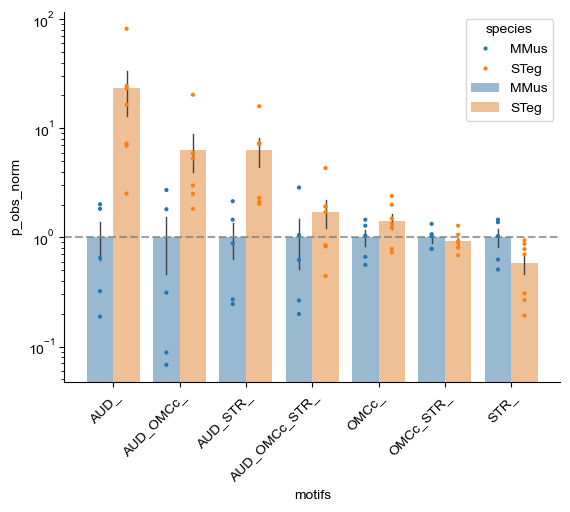

In [126]:
dot_bar_plot(it_motifs_df, xaxis="motifs", yaxis="p_obs_norm",
             hueaxis="species", order = fc_order)
plt.yscale("log")
plt.axline((0,1), (1,1), color="gray", linestyle="--", alpha=0.75)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  # plot unity line


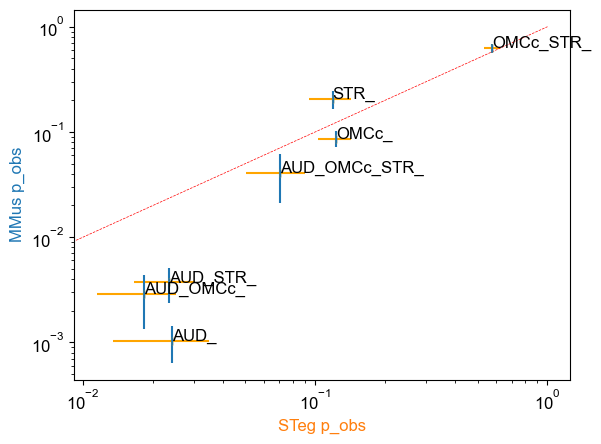

In [139]:
# scatterplot
stvmm_area_scatter(it_motifs_df, to_plot="p_obs", groupby="motifs", log=True)
plt.show()

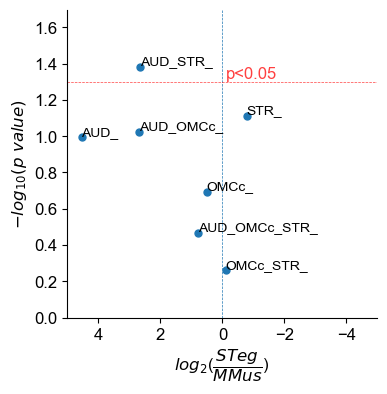

In [137]:
# volcano plot
ttest = proportion_ttest(it_motifs_df, to_plot="p_obs", groupby="motifs")
plot_volcano(ttest, labels="motifs", p_01=False, xlim=(5,-5), legend_loc=None)
plt.show()

In [39]:
df = omc_it[0].sum()
df["OMCc"]

5607.0

0

In [42]:
test = ["A", "B", "C", "D", "E", "F", "G", "H"]
vals = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "H":8}

plot_areas = ["OMCc", "AUD", "STR"]



In [68]:

def calculate_n_total(df, areas):
    n_obs = df.shape[0]
    n_areas = df.sum()
    all_terms = []
    for k in range(1, len(plot_areas)+1):
        combos = list(combinations(plot_areas, k))
        term = 0
        for i in range(len(combos)):
            product = 1
            for j in range(len(combos[i])):
                n_area = n_areas[combos[i][j]]
                product = product*n_area
            term = term + product
        all_terms.append(term)

    # need to subtract first term from n_obs
    all_terms[0] = n_obs - all_terms[0]

    # multiply every other by -1 starting w/ 3rd term
    for l in range(len(all_terms)):
        if l>=2 and l%2==0:
            all_terms[l] = -1*all_terms[l]

    # find roots of polynomial
    roots = np.roots(all_terms)

    # convert to real numbers if numbers complex
    if isinstance(roots[0],complex):
        reals = []
        for num in roots:
            if num.imag==0:
                reals.append(num.real)
    else:
        reals = roots.copy()

    # pick root that is more than n_obs
    # if can't find root more than n_obs, return n_obs as n_total
    n_total = n_obs
    for num in reals:
        if num > n_obs:
            n_total = round(num)

    return(n_total)

In [69]:
plot_areas = ['TH', 'HY', 'AMY', 'SNr', 'SCm', 'PG',
       'PAG', 'BS']
n_total = calculate_n_total(omc_pt[0], plot_areas)
n_total

1318

[1318.066654514159, 103.83064027551005, 25.000002800996064]

In [ ]:
1318

In [ ]:

# multiply odd terms 3 or greater by -1
for l in range(len(3)):
    if l>=3 and l%2==1:
        all_terms[l] = -1*all_terms[l]

# PT Motifs

### Apply $N_{total}$ calculation to real data

- Taken from Methods section of Han et al., 2017
$$
\frac{N_{obs}}{N_{total}} + \Pi_{i=1}^k(1-\frac{N_{Ai}}{N_{total}}) = 1
$$
For 8 areas, k=8, then expand that to:
$$
(N_{obs}-N_{A1}-N_{A2}-N_{A3})N_{total}^{2} + (N_{A1}N_{A2} + N_{A1}N_{A3} + N_{A2}N_{A3})N_{total} - (N_{A1}N_{A2}N_{A3}) = 0
$$